# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [2]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [ ]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from sklearn.cluster import DBSCAN as db

datadir = 'images/'
utilfn = datadir + "utils"



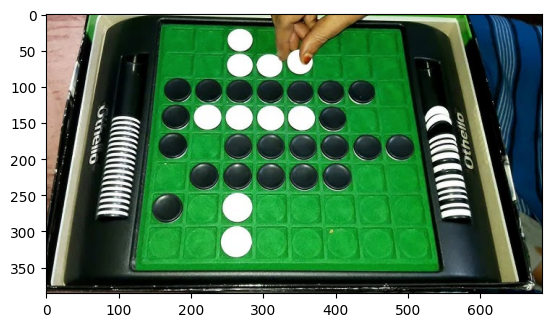

In [ ]:
test_img = 'othello.png'
img = np.float32(cv2.imread(datadir+test_img, cv2.IMREAD_COLOR_RGB) / 255.0)
test_img = 'othello2.png'
img2 = np.float32(cv2.imread(datadir+test_img, cv2.IMREAD_COLOR_RGB) / 255.0)
test_img = 'othello.png'
img3 = np.float32(cv2.imread(datadir+test_img, cv2.IMREAD_COLOR_RGB) / 255.0)
plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

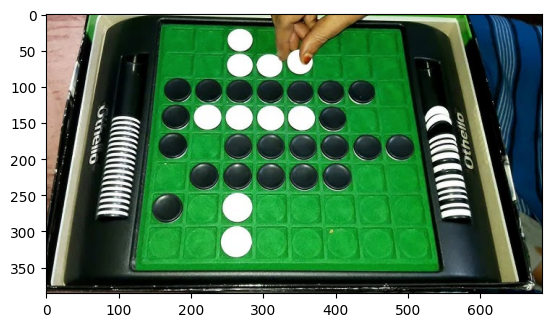

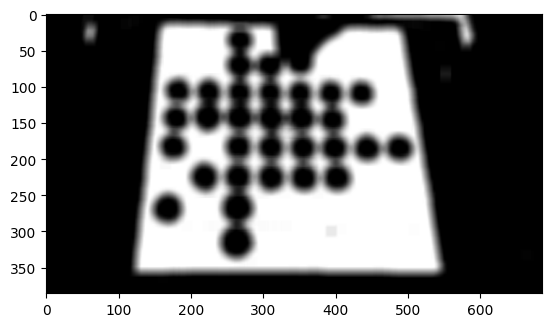

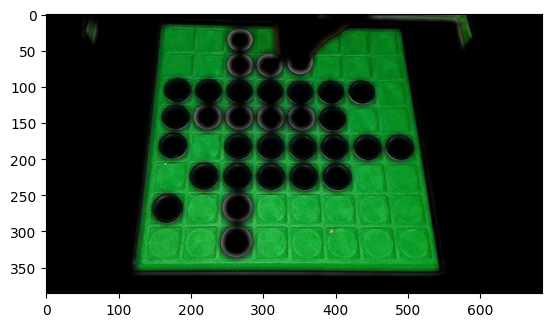

In [20]:
def prep_image(img, chroma_key,sigma,ksize, threshold):
    oned_fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
    twod_fil = oned_fil*np.transpose(oned_fil)

    im_fil_low = img.copy()#cv2.filter2D(img,-1,twod_fil)
    
    dim = 3 if len(im_fil_low.shape) == 3 else 1

    for i in range (im_fil_low.shape[0]):
        for j in range(im_fil_low.shape[1]):
            color = img[i][j]
            difference = np.abs(chroma_key-color)
            im_fil_low[i][j] = np.ones(dim) if (np.sum(difference) < threshold) else np.zeros(dim)
    
    im_fil_low = np.clip(cv2.filter2D(im_fil_low,-1,twod_fil),0,1)
    plt.imshow(im_fil_low)
    plt.show()
    
    return im_fil_low
    

plt.imshow(img)
plt.show()

mask = prep_image(img,[0,1,0],30,15, 0.95)
masked_img = mask*img

plt.imshow(masked_img)
plt.show()

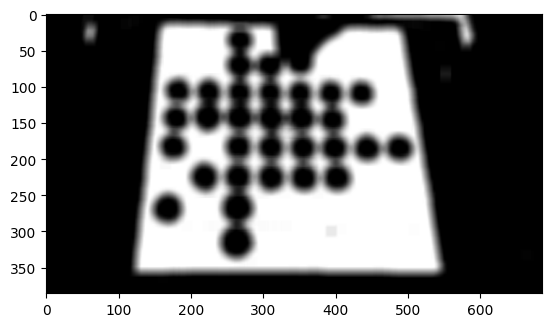

[390, 363]
[595, 26]
[51, 0]
[48, 23]


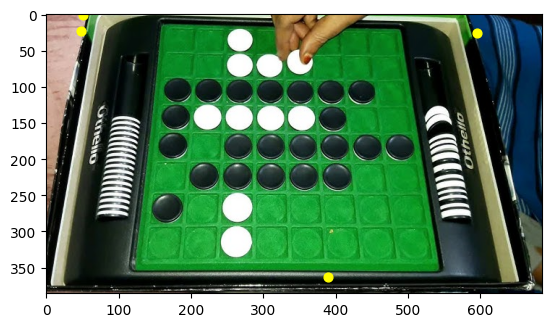

In [21]:
def chroma_key(img):
    mask = prep_image(img,[0,1,0],30,15, 0.95)
    masked_img = mask*img

    top = [-1,-1]
    bottom = [9999,9999]
    left = [9999,9999]
    right = [-1,-1]
    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            if masked_img[j][i][2] > 0.015:
                if(j > top[1]):
                    top = [i,j]
                if(j < bottom[1]):
                    bottom = [i,j]
                if(i < left[0]):
                    left = [i,j]
                if(i > right[0]):
                    right = [i,j]
    
    return [top,right,bottom,left]

corners = chroma_key(img)
plt.imshow(img)
for corner in corners:
    plt.scatter(corner[0], corner[1], color='yellow', s=40, marker='o')
    print(corner)

plt.show()


In [22]:
from itertools import product
def compute_line(line):
    """Returns line coefficients (a, b, c) from points: ax + by + c = 0"""
    a = line[1] - line[3]
    b = line[2] - line[0]
    c = line[0]*line[3] - line[2]*line[1]
    return a, b, -c

def intersection(L1, L2):
    """Find intersection point of two lines given in ax + by + c = 0 form"""
    D = L1[0] * L2[1] - L1[1] * L2[0]
    if D == 0:
        return None  # parallel lines
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    x = Dx / D
    y = Dy / D
    return x, y

def hough(img):
    plt.imshow(img)
    plt.show()

    mask = prep_image(img,(0,1,0),10,(int)(img.shape[0]/10),0.95)
    masked_img =  (mask*img * 255).astype(np.uint8)
    plt.imshow(masked_img)
    plt.show()

    masked_gray =  cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(masked_gray,img.shape[0]//20,img.shape[0]//10)
    plt.imshow(edges)
    plt.show()
    
    lines = cv2.HoughLinesP(edges,rho=1,theta=np.pi / 180,threshold=100,minLineLength=img.shape[0]/4,maxLineGap=img.shape[0]//10)
    line_detection_img = img.copy()

    rho_theta = []
    for x1,y1,x2,y2 in lines[:,0]:
        theta = np.arctan2(y2-y1, x2-x1) + np.pi/2
        rho = x1*np.cos(theta) + y1*np.sin(theta)
        rho_theta.append([rho, theta])
    rho_theta = np.array(rho_theta)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    rt_scaled = scaler.fit_transform(rho_theta)
    labels = db(eps=1, min_samples=2).fit_predict(rt_scaled)

    vertical = []
    horizontal = []
    color = np.random.randint(0, 256, size=3).tolist()
    for i in range(len(lines)):
        x1,y1,x2,y2 = lines[i][0]
        color = [1,0,0] if labels[i] else [0,0,1]
        cv2.line(line_detection_img, (x1, y1), (x2, y2), color, 3)
        if labels[i]:
            vertical.append(lines[i][0])
        else:
            horizontal.append(lines[i][0])
    
    points = []
    for a, b in product(vertical, horizontal):
        L1 = compute_line(a)
        L2 = compute_line(b)
        pt = intersection(L1, L2)
        if pt:
            points.append(pt)
            plt.scatter(pt[0], pt[1], color='pink', s=5, marker='o')
    points = np.array(points)
    plt.imshow(line_detection_img)
    plt.show()

    from sklearn.cluster import KMeans
    k = 81  # number of clusters
    kmeans = KMeans(n_clusters=k, n_init='auto')
    labels = kmeans.fit_predict(points)
    centroids = kmeans.cluster_centers_
    plt.imshow(img)
    plt.scatter(centroids[:,0],centroids[:,1], color='yellow', s=5, marker='o')
    plt.show()

    top = [-1,-1]
    bottom = [9999,9999]
    left = [9999,9999]
    right = [-1,-1]
    for p in centroids.astype(int):
        if(p[1] > top[1]):
            top = p
        if(p[1] < bottom[1]):
            bottom = p
        if(p[0] < left[0]):
            left = p
        if(p[0] > right[0]):
            right = p
    
    return [top,right,bottom,left]

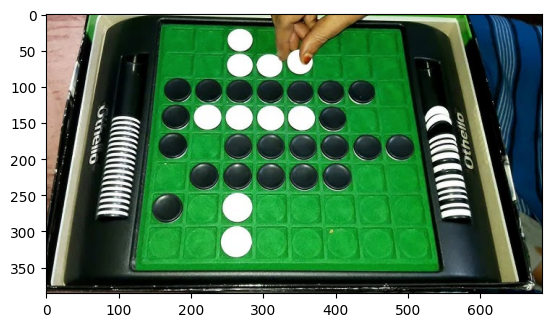

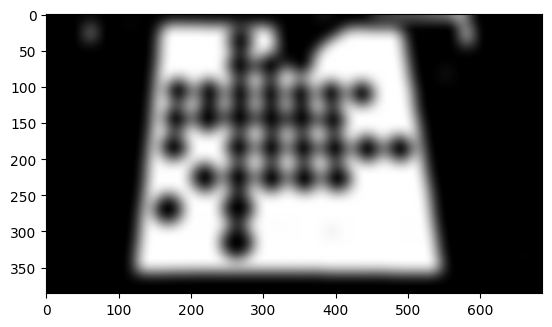

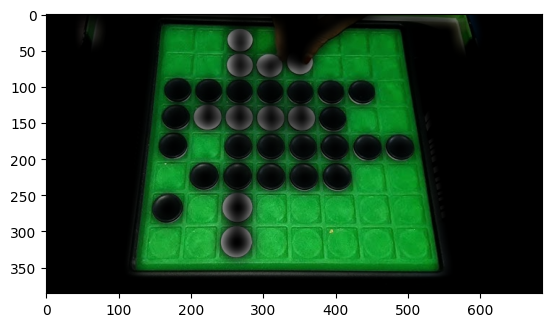

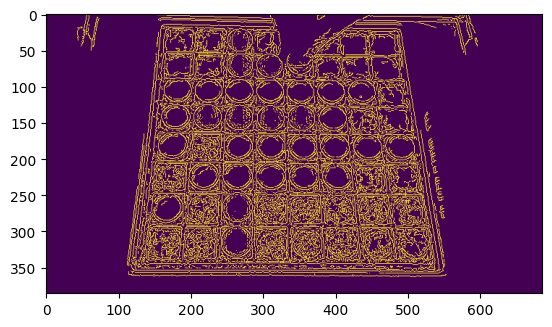

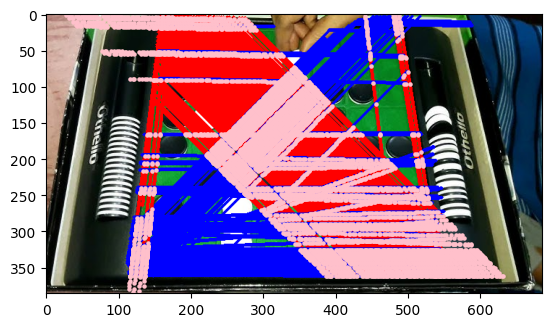

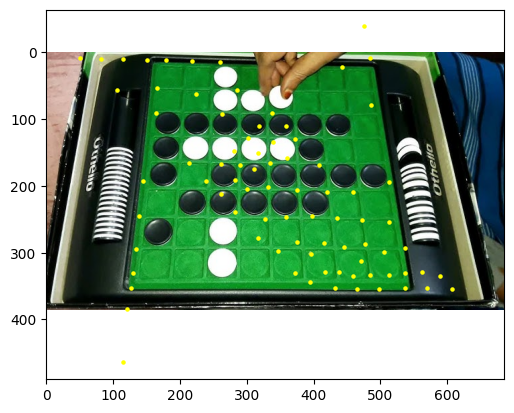

[114 464]
[607 354]
[475 -38]
[49  8]


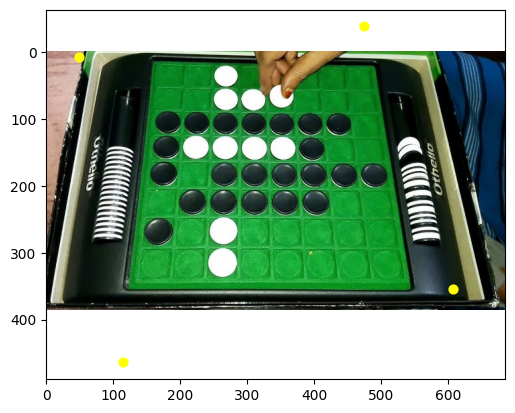

[array([114, 464]), array([607, 354]), array([475, -38]), array([49,  8])]


In [24]:
corners = hough(img)
plt.imshow(img)
for corner in corners:
    plt.scatter(corner[0], corner[1], color='yellow', s=40, marker='o')
    print(corner)

plt.show()
print(corners)